In [1]:
import gc
import os
import random
import csv
import sys
import json
import datetime

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from numba import jit
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_rows', 300)
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 300)

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm import tqdm

plt.style.use("seaborn")
sns.set(font_scale=1)

sample_submission = pd.read_csv("../input/data-science-bowl-2019/sample_submission.csv")
specs = pd.read_csv("../input/data-science-bowl-2019/specs.csv")
test = pd.read_csv("../input/data-science-bowl-2019/test.csv")
train = pd.read_csv("../input/data-science-bowl-2019/train.csv")
train_labels = pd.read_csv("../input/data-science-bowl-2019/train_labels.csv")
# test_labels = pd.read_csv("../input/dsb-each-attemption-result-in-test-data/results_in_test_agg.csv")

specs = specs.rename(columns={'info': 'information'})
specs["information"] = specs["information"].str[:40]
train["timestamp"] = pd.to_datetime(train['timestamp'])
test["timestamp"] = pd.to_datetime(test['timestamp'])

In [2]:
def prepare(df,test=False):
    keep_id = df[df.type == "Assessment"][['installation_id']].drop_duplicates()
    df = pd.merge(df, keep_id, on="installation_id", how="inner")
    attempt = df[((df.type=="Assessment") & (((df.event_code==4110) & (df.title=="Bird Measurer (Assessment)")) | ((df.event_code==4100) & (df.title!="Bird Measurer (Assessment)"))))]
    attempt.drop(["event_count", "event_code", "game_time"], axis=1, inplace=True)
    X = pd.DataFrame()
    for iid in tqdm(keep_id.installation_id):
        sample_id = attempt[attempt.installation_id == iid].reset_index()
        if(len(sample_id)==0):
            continue
        edata = pd.io.json.json_normalize(sample_id.event_data.apply(json.loads))
        sample_id = sample_id.join(edata)
        X = X.append(sample_id,ignore_index=True)
    X.drop(["event_data"],axis=1,inplace=True)
    X.drop(["index","buckets","buckets_placed","caterpillars","duration","left","pillars","right","stumps","timestamp"],axis=1,inplace=True)
    
#     le = LabelEncoder()
#     X.title = le.fit_transform(X.title)
#     X.type = le.fit_transform(X.type)
#     X.world = le.fit_transform(X.world)
    X.loc[X.correct==True,'target'] = 1
    X.loc[X.correct==False,'target'] = 0
    return X

def agg(df):
    df_agg = df.groupby(["installation_id","game_session"])["target"].agg({"num_collect":np.sum, "num_attempt":len})
    df_agg["accuracy"] = df_agg.num_collect/df_agg.num_attempt
    df_agg["accuracy_group"] = 0
    df_agg.loc[(df_agg.num_collect>0) & (df_agg.num_attempt==1),"accuracy_group"] = 3
    df_agg.loc[(df_agg.num_collect>0) & (df_agg.num_attempt==2),"accuracy_group"] = 2
    df_agg.loc[(df_agg.num_collect>0) & (df_agg.num_attempt>2),"accuracy_group"] = 1
    return df_agg

In [3]:
test_labels = prepare(test,True)
test_labels = agg(test_labels)
test_labels = test_labels.reset_index()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
100%|██████████| 1000/1000 [00:12<00:00, 81.71it/s]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_

In [4]:
keep_id = train_labels[['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")
train = pd.merge(train,specs.loc[:,["event_id","information"]],on="event_id", how="left")
test = pd.merge(test,specs.loc[:,["event_id","information"]],on="event_id", how="left")

In [5]:
le_id = LabelEncoder()
le_id.fit_transform(pd.concat((train.installation_id,test.installation_id),axis=0).unique())
train.installation_id= le_id.transform(train.installation_id)
train_labels.installation_id= le_id.transform(train_labels.installation_id)
test.installation_id= le_id.transform(test.installation_id)
test_labels.installation_id= le_id.transform(test_labels.installation_id)

le = LabelEncoder()
le.fit_transform(pd.concat((train.game_session,test.game_session),axis=0).unique())
train.game_session= le.transform(train.game_session)
train_labels.game_session= le.transform(train_labels.game_session)
test.game_session= le.transform(test.game_session)
test_labels.game_session= le.transform(test_labels.game_session)

le_info = LabelEncoder()
le_info.fit_transform(specs.information)
train.information = le_info.transform(train.information)
test.information = le_info.transform(test.information)

In [6]:
df_info = pd.DataFrame({'info':le_info.classes_, 'code':le_info.transform(le_info.classes_)}).head(200)
asslist = train_labels.title.unique()
infolist = range(df_info.code.max()+1)
codelist = train.event_code.unique()
typlist = train.type.unique()#["Clip", "Game", "Activity", "Assessment"]
desc_in_infolist = ["GreatJob", "WhoaSoCool", "Amazing", "GoLower","Dot_Wow", "SoHigh", "NEXTSTONE", "NOT_THAT_HEAVY","RIGHTANSWER1","water_success"]
# print(asslist)

In [7]:
def features(X_df,df,stime):
    cnz = np.count_nonzero
    grp = df.groupby("game_session")
    typ = df.type
    evcode = df.event_code
    evcount1 = df.event_count == 1
    info = df.information
    X_df["sum_max_count"] = grp["event_count"].max().sum()
    X_df["mean_max_gametime"] = grp["game_time"].max().mean()#//(60*15)
    X_df["std_max_gametime"] = grp["game_time"].max().std()#//(60*15)
    X_df["sum_max_gametime"] = grp["game_time"].max().sum()#//(60*15)
    X_df["unique_game_session"] = df.game_session.nunique()
    X_df["unique_title"] = df.title.nunique()

    for i in typlist:
        X_df["count_{}".format(i)] = cnz((typ == i) & (evcount1))
    for i in codelist:
        X_df["count_{}".format(i)] = cnz(evcode == i)
    for i in infolist:
        X_df["count_info_{}".format(i)] = cnz(info == i)
        
    ### last session ###
    X_df["time_from_last_session"] = (stime - df.timestamp.max()).seconds#//(60*15)#10minuts
    
    df_last = df[df.timestamp == df.timestamp.max()].copy()
#    if len(df_last) == 0:
#        X_df["last_session_title"] = "None"
#    else:
#        X_df["last_session_title"] = df_last.title.max()
    if len(df_last) == 0:
        X_df["last_session_type"] = "None"
    else:
        X_df["last_session_type"] = df_last.type.max()
    X_df["last_session_max_count"] = df_last["event_count"].max()
    X_df["last_session_max_gametime"] = df_last["game_time"].max()#//(60*15)
    
#     ### last2 session ###
#     last_gs = df_last.game_session.max()
#     df_last2 = df[df.game_session != last_gs].copy()
#     df_last2 = df_last2[df_last2.timestamp == df_last2.timestamp.max()].copy()
#     X_df["time_from_last2_session"] = (stime - df_last2.timestamp.max()).total_seconds()
# #     if len(df_last2) == 0:
# #         X_df["last2_session_title"] = "None"
# #     else:
# #         X_df["last2_session_title"] = df_last2.title.max()
#     X_df["last2_session_max_count"] = df_last2["event_count"].max()
#     X_df["last2_session_max_gametime"] = df_last2["game_time"].max()
    
#     ### last3 session ###
#     last2_gs = df_last2.game_session.max()
#     df_last3 = df_last2[df_last2.game_session != last_gs].copy()
#     df_last3 = df_last3[df_last3.timestamp == df_last3.timestamp.max()].copy()
#     X_df["time_from_last3_session"] = (stime - df_last3.timestamp.max()).total_seconds()
# #     if len(df_last3) == 0:
# #         X_df["last3_session_title"] = "None"
# #     else:
# #         X_df["last3_session_title"] = df_last3.title.max()
#     X_df["last3_session_max_count"] = df_last3["event_count"].max()
#     X_df["last3_session_max_gametime"] = df_last3["game_time"].max()
    
    ### assessment ###
    df_ass = df[(typ=="Assessment") & (((evcode==4110) & (df.title=="Bird Measurer (Assessment)")) | ((evcode==4100) & (df.title!="Bird Measurer (Assessment)")))].copy()
    X_df["count_correct"] = df_ass.event_data.str.contains('"correct":true').sum()
    X_df["count_incorrect"] = df_ass.event_data.str.contains('"correct":false').sum()
    if X_df.count_correct.max()+X_df.count_incorrect.max() == 0:
        X_df["rate_correct"] = -1
    else:
        X_df["rate_correct"] = X_df.count_correct.max()/(X_df.count_correct.max()+X_df.count_incorrect.max())
    for i in asslist:
        X_df["count_correct_{}".format(i)] = df_ass[df_ass.title == i].event_data.str.contains('"correct":true').sum()
        X_df["count_incorrect_{}".format(i)] = df_ass[df_ass.title == i].event_data.str.contains('"correct":false').sum()
        if X_df["count_correct_{}".format(i)].max()+X_df["count_incorrect_{}".format(i)].max() == 0:
            X_df["rate_correct_{}".format(i)] = -1
        else:
            X_df["rate_correct_{}".format(i)] = X_df["count_correct_{}".format(i)].max()/(X_df["count_correct_{}".format(i)].max()+X_df["count_incorrect_{}".format(i)].max())
    
    ### last assessment ###
    last_ass_gs = df_ass[df_ass.timestamp == df_ass.timestamp.max()].game_session.max()
    df_last_ass = df_ass[df_ass.game_session == last_ass_gs].copy()
    if len(df_last_ass) == 0:
        X_df["last_ass_title"] = "None"
    else:
        X_df["last_ass_title"] = df_last_ass.title.max()
    X_df["last_count_correct"] = df_last_ass.event_data.str.contains('"correct":true').sum()
    X_df["last_count_incorrect"] = df_last_ass.event_data.str.contains('"correct":false').sum()
    X_df["time_from_last_ass"] = (stime - df_last_ass.timestamp.max()).seconds#//(60*15) #10分単位
    
#     ### last 7 day ###
#     df_7days = df[(stime - df.timestamp).apply(lambda x: x.days < 7)].copy()
#     if len(df_7days) == 0:
#         return X_df
#     X_df["7days_sum_max_count"] = df_7days.groupby("game_session")["event_count"].max().sum()
#     X_df["7days_mean_max_gametime"] = df_7days.groupby("game_session")["game_time"].max().mean()#//(60*15)
#     X_df["7days_std_max_gametime"] = df_7days.groupby("game_session")["game_time"].max().std()#//(60*15)
#     X_df["7days_sum_max_gametime"] = df_7days.groupby("game_session")["game_time"].max().sum()#//(60*15)
#     X_df["7days_unique_game_session"] = df_7days.game_session.nunique()
#     X_df["7days_unique_title"] = df_7days.title.nunique()
#     for i in typlist:
#         X_df["7days_count_{}".format(i)] = cnz((df_7days.type == i) & (df_7days.event_count == 1))
    
#     ### last 1 day ###
#     df_today = df[(stime - df.timestamp).apply(lambda x: x.days < 1)].copy()
#     if len(df_today) == 0:
#         return X_df
#     X_df["today_sum_max_count"] = df_today.groupby("game_session")["event_count"].max().sum()
#     X_df["today_mean_max_gametime"] = df_today.groupby("game_session")["game_time"].max().mean()#//(60*15)
#     X_df["today_std_max_gametime"] = df_today.groupby("game_session")["game_time"].max().std()#//(60*15)
#     X_df["today_sum_max_gametime"] = df_today.groupby("game_session")["game_time"].max().sum()#//(60*15)
#     X_df["today_unique_game_session"] = df_today.game_session.nunique()
#     X_df["today_unique_title"] = df_today.title.nunique()
#     for i in typlist:
#         X_df["today_count_{}".format(i)] = cnz((df_today.type == i) & (df_today.event_count == 1))

#     for i in desc_in_infolist:
#         X_df["count_{}".format(i)] = df.event_data.str.contains(i).sum()
#     hour = stime.hour
#     X_df["hour_cos"] = np.cos(2 * np.pi * hour / 24)
#     X_df["hour_sin"] = np.sin(2 * np.pi * hour / 24)
#    df_today = df[(df.timestamp.dt.month == stime.month) & (df.timestamp.dt.day == stime.day)].copy()
#    X_df["today_sum_max_count"] = df_today.groupby("game_session")["event_count"].max().sum()
#    X_df["today_mean_max_gametime"] = df_today.groupby("game_session")["game_time"].max().mean()
#    X_df["today_sum_max_gametime"] = df_today.groupby("game_session")["game_time"].max().sum()
#    X_df["today_duration_gametime"] = df_today.groupby("game_session")["game_time"].max().sum()/len(df_today)
#    X_df["today_unique_game_session"] = df_today.game_session.nunique()
#    for i in typlist:
#        X_df["today_count_{}".format(i)] = cnz((df_today.type == i) & (df_today.event_count == 1))

    return X_df

In [8]:
def make_dat(X_df,df):
    df_out = pd.DataFrame()
    ids = X_df.installation_id.unique()
    for id in tqdm(ids):
        df_id = df[df.installation_id == id]
        X_df_id = X_df[X_df.installation_id == id]
        sessions = X_df_id.game_session.unique()
        for gs in sessions:
            X_df_id_gs = X_df_id[X_df_id.game_session == gs]
            stime = df_id[df_id.game_session == gs].iloc[0].timestamp
            dfgs = features(X_df_id_gs.copy(),df_id[(df_id.timestamp < stime) & ((stime - df_id.timestamp).apply(lambda x: x.days <= 21))].copy(),stime)
            df_out = df_out.append(dfgs)         
    return df_out

In [9]:
print(len(train_labels))
X_train = train_labels.merge(train[((train.type=="Assessment") &  (train.event_count==1))].loc[:,["game_session","installation_id","world","timestamp"]],on=["installation_id","game_session"],how="left")
X_train.drop(["timestamp"],axis=1,inplace=True)
y_train = X_train.accuracy_group

17690


In [10]:
# X_train = X_train.head(100) # for develop
X_train = make_dat(X_train, train)
print(X_train.columns)

100%|██████████| 3614/3614 [1:29:11<00:00,  1.48s/it]

Index(['game_session', 'installation_id', 'title', 'num_correct',
       'num_incorrect', 'accuracy', 'accuracy_group', 'world', 'sum_max_count',
       'mean_max_gametime',
       ...
       'count_correct_Chest Sorter (Assessment)',
       'count_incorrect_Chest Sorter (Assessment)',
       'rate_correct_Chest Sorter (Assessment)',
       'count_correct_Cart Balancer (Assessment)',
       'count_incorrect_Cart Balancer (Assessment)',
       'rate_correct_Cart Balancer (Assessment)', 'last_ass_title',
       'last_count_correct', 'last_count_incorrect', 'time_from_last_ass'],
      dtype='object', length=126)


In [11]:
X_test = test[(test.type=="Assessment") & (test.event_count==1)].loc[:,["game_session","installation_id","title","world","timestamp"]].copy()
# X_test = X_test.head(100) # for develop
X_test = make_dat(X_test,test)
print(X_test.columns)

100%|██████████| 1000/1000 [13:55<00:00,  1.20it/s]

Index(['game_session', 'installation_id', 'title', 'world', 'timestamp',
       'sum_max_count', 'mean_max_gametime', 'std_max_gametime',
       'sum_max_gametime', 'unique_game_session',
       ...
       'count_correct_Chest Sorter (Assessment)',
       'count_incorrect_Chest Sorter (Assessment)',
       'rate_correct_Chest Sorter (Assessment)',
       'count_correct_Cart Balancer (Assessment)',
       'count_incorrect_Cart Balancer (Assessment)',
       'rate_correct_Cart Balancer (Assessment)', 'last_ass_title',
       'last_count_correct', 'last_count_incorrect', 'time_from_last_ass'],
      dtype='object', length=123)


In [12]:
counter = 0
to_remove = []
features = X_train.columns
for feat_a in features:
    for feat_b in features:
        if type(X_train[feat_a].max()) is str or type(X_train[feat_b].max()) is str:
            continue
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(X_train[feat_a], X_train[feat_b])[0][1]
            if c > 0.9:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: accuracy FEAT_B: accuracy_group - Correlation: 0.9881500925989148
2: FEAT_A: sum_max_count FEAT_B: count_Activity - Correlation: 0.9404026669374195
3: FEAT_A: sum_max_count FEAT_B: count_Game - Correlation: 0.9012932555062008
4: FEAT_A: sum_max_count FEAT_B: count_3010 - Correlation: 0.9765114302843464
5: FEAT_A: sum_max_count FEAT_B: count_3110 - Correlation: 0.9754307549187818
6: FEAT_A: sum_max_count FEAT_B: count_4030 - Correlation: 0.9682920583882965
7: FEAT_A: sum_max_count FEAT_B: count_4020 - Correlation: 0.9865066613402631
8: FEAT_A: sum_max_count FEAT_B: count_2020 - Correlation: 0.9538760166111938
9: FEAT_A: sum_max_count FEAT_B: count_2030 - Correlation: 0.9367407274713441
10: FEAT_A: sum_max_count FEAT_B: count_3021 - Correlation: 0.9349632108860735
11: FEAT_A: sum_max_count FEAT_B: count_3121 - Correlation: 0.933896498915462
12: FEAT_A: sum_max_count FEAT_B: count_3020 - Correlation: 0.9233258872389157
13: FEAT_A: sum_max_count FEAT_B: count_3120 - Correlation:

In [13]:
print(to_remove)
to_remain = ["accuracy","accuracy_group","num_correct","num_incorrect"]
features = [x for x in X_train.columns if x not in to_remove or x in to_remain]
X_train = X_train[features]
features = [x for x in X_test.columns if x not in to_remove or x in to_remain]
X_test = X_test[features]

['accuracy_group', 'count_Activity', 'count_Game', 'count_3010', 'count_3110', 'count_4030', 'count_4020', 'count_2020', 'count_2030', 'count_3021', 'count_3121', 'count_3020', 'count_3120', 'count_4025', 'count_info_1', 'count_info_2', 'count_info_3', 'count_info_4', 'count_info_15', 'count_info_18', 'count_info_20', 'count_info_21', 'count_info_22', 'count_info_28', 'count_info_29', 'count_info_36', 'count_info_37', 'count_Clip', 'count_2000', 'count_info_23', 'count_info_17', 'count_info_35', 'count_2040', 'count_2050', 'count_2083', 'count_info_0', 'count_info_9', 'count_info_11', 'count_info_16', 'count_info_10', 'count_2035', 'count_info_6', 'count_correct', 'count_info_19', 'count_info_5', 'count_info_24', 'count_incorrect_Bird Measurer (Assessment)', 'count_5010', 'count_info_25', 'count_info_34', 'count_4235', 'count_info_32', 'count_info_33', 'count_info_14', 'count_info_27']


In [14]:
X_train.head(10)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,world,sum_max_count,mean_max_gametime,std_max_gametime,sum_max_gametime,unique_game_session,unique_title,count_Assessment,count_4070,count_4021,count_4090,count_4010,count_2080,count_2081,count_2025,count_4035,count_4022,count_4040,count_4100,count_2010,count_2060,count_2070,count_4110,count_5000,count_4031,count_4045,count_4095,count_4220,count_2075,count_4230,count_4080,count_4050,count_info_7,count_info_8,count_info_12,count_info_13,count_info_26,count_info_30,count_info_31,count_info_38,count_info_39,time_from_last_session,last_session_type,last_session_max_count,last_session_max_gametime,count_incorrect,rate_correct,count_correct_Mushroom Sorter (Assessment),count_incorrect_Mushroom Sorter (Assessment),rate_correct_Mushroom Sorter (Assessment),count_correct_Bird Measurer (Assessment),rate_correct_Bird Measurer (Assessment),count_correct_Cauldron Filler (Assessment),count_incorrect_Cauldron Filler (Assessment),rate_correct_Cauldron Filler (Assessment),count_correct_Chest Sorter (Assessment),count_incorrect_Chest Sorter (Assessment),rate_correct_Chest Sorter (Assessment),count_correct_Cart Balancer (Assessment),count_incorrect_Cart Balancer (Assessment),rate_correct_Cart Balancer (Assessment),last_ass_title,last_count_correct,last_count_incorrect,time_from_last_ass
0,86075,0,Mushroom Sorter (Assessment),1,0,1.0,3,TREETOPCITY,1230,43688.923077,58010.660128,1135912,26,22,2,160,14,4,6,4,1,5,6,31,2,5,1,1,1,13,0,0,0,0,0,0,0,0,0,0,2,4,0,23,19,0,0,18,58.0,Assessment,87.0,92799.0,11,0.083333,1,0,1.000000,0,0.0,0,0,-1.0,0,0,-1.0,0,0,-1.0,Bird Measurer (Assessment),0,11,60.0
1,95597,0,Bird Measurer (Assessment),0,11,0.0,0,TREETOPCITY,1143,41724.520000,58317.609394,1043113,25,21,1,156,14,4,6,4,1,5,6,31,2,5,1,1,1,2,0,0,0,0,0,0,0,0,0,0,2,4,0,23,19,0,0,18,14.0,Activity,204.0,104816.0,0,1.000000,1,0,1.000000,0,-1.0,0,0,-1.0,0,0,-1.0,0,0,-1.0,Mushroom Sorter (Assessment),1,0,766.0
2,114978,0,Mushroom Sorter (Assessment),1,0,1.0,3,TREETOPCITY,647,34806.500000,52720.984532,626517,18,14,0,94,14,4,4,4,1,4,1,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,23,19,0,0,18,57.0,Clip,1.0,0.0,0,-1.000000,0,0,-1.000000,0,-1.0,0,0,-1.0,0,0,-1.0,0,0,-1.0,None,0,0,NaN
3,118906,0,Mushroom Sorter (Assessment),1,1,0.5,2,TREETOPCITY,2159,73536.829787,222477.234234,3456231,47,27,4,348,29,4,10,8,2,9,14,45,9,6,2,2,2,13,5,6,2,1,9,0,0,0,0,2,2,4,0,70,38,22,21,37,9.0,Assessment,17.0,8789.0,11,0.153846,2,0,1.000000,0,0.0,0,0,-1.0,0,0,-1.0,0,0,-1.0,Mushroom Sorter (Assessment),1,0,53805.0
4,135589,0,Bird Measurer (Assessment),1,0,1.0,3,TREETOPCITY,2586,70448.125000,206056.254307,3945095,56,27,5,387,29,4,12,8,2,10,15,45,10,12,3,3,2,13,5,6,2,1,9,1,0,0,0,2,9,4,1,70,38,22,21,37,11.0,Activity,115.0,80899.0,12,0.200000,3,1,0.750000,0,0.0,0,0,-1.0,0,0,-1.0,0,0,-1.0,Mushroom Sorter (Assessment),1,1,882.0
5,20353,1,Cauldron Filler (Assessment),1,0,1.0,3,MAGMAPEAK,1542,53140.960000,93231.770494,1328524,25,15,0,482,65,2,5,4,1,1,30,0,8,0,0,1,1,0,0,0,1,1,5,0,6,0,0,1,0,0,0,0,0,0,46,0,50.0,Clip,1.0,0.0,0,-1.000000,0,0,-1.000000,0,-1.0,0,0,-1.0,0,0,-1.0,0,0,-1.0,None,0,0,NaN
6,119242,1,Bird Measurer (Assessment),1,1,0.5,2,TREETOPCITY,2022,39304.042553,80653.005512,1847290,47,30,3,577,65,3,7,4,1,2,45,37,14,5,0,1,1,0,0,0,1,1,5,0,6,0,0,1,0,0,0,0,16,0,46,20,28.0,Game,6.0,11949.0,4,0.200000,0,4,0.000000,0,-1.0,1,0,1.0,0,0,-1.0,0,0,-1.0,Mushroom Sorter (Assessment),0,4,291.0
7,142145,1,Mushroom Sorter (Assessment),0,4,0.0,0,TREETOPCITY,1898,40546.813953,83461.231813,1743513,43,26,2,521,65,3,6,4,1,1,45,37,8,1,0,1,1,0,0,0,1,1,5,0,6,0,0,1,0,0,0,0,16,0,46,20,89.0,Clip,1.0,0.0,0,1.000000,0,0,-1.000000,0,-1.0,1,0,1.0,0,0,-1.0,0,0,-1.0,Cauldron Filler (Assessment),1,0,33424.0
8,139160,2,Bird Measurer (Assessment),1,0,1.0,3,TREETOPCITY,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,None,NaN,NaN,0,-1.000000,0,0,-1.000000,0,-1.0,0,0,-1.0,0,0,-1.0,0,0,-1.0,None,0,0,NaN
9,98396,3,Bir

In [15]:
le = LabelEncoder()
X_train.title= le.fit_transform(X_train.title)
X_test.title= le.transform(X_test.title)

#le = LabelEncoder()
#le.fit_transform(pd.concat((train.title,X_train.last_session_title),axis=0).unique())
#X_train.last_session_title= le.transform(X_train.last_session_title)
#X_test.last_session_title= le.transform(X_test.last_session_title)

le = LabelEncoder()
le.fit_transform(pd.concat((train.type,X_train.last_session_type),axis=0).unique())
X_train.last_session_type= le.transform(X_train.last_session_type)
X_test.last_session_type= le.transform(X_test.last_session_type)

# le = LabelEncoder()
# le.fit_transform(pd.concat((train.title,X_train.last2_session_title),axis=0).unique())
# X_train.last2_session_title= le.transform(X_train.last2_session_title)
# X_test.last2_session_title= le.transform(X_test.last2_session_title)

le = LabelEncoder()
le.fit_transform(pd.concat((train_labels.title,X_train.last_ass_title),axis=0).unique())
X_train.last_ass_title= le.transform(X_train.last_ass_title)
X_test.last_ass_title= le.transform(X_test.last_ass_title)

le = LabelEncoder()
X_train.world= le.fit_transform(X_train.world)
X_test.world= le.transform(X_test.world)

In [16]:
X_train.drop(["installation_id","game_session"],axis=1,inplace=True)
X_te = X_test.copy()
X_te.drop(["installation_id","game_session","timestamp"],axis=1,inplace=True)
#X_te.drop(["game_session","timestamp"],axis=1,inplace=True)

In [17]:
X_train_origin = X_train.copy()
y_train_origin = y_train.copy()
train_labels_origin = train_labels.copy()

In [18]:
val = X_test.merge(test_labels.loc[:,["installation_id","game_session","accuracy_group"]],on=["installation_id","game_session"],how="left").copy()
val = val[~np.isnan(val.accuracy_group)]
val_x = val.copy()
val_x.drop(["installation_id","game_session","timestamp","accuracy_group"],axis=1,inplace=True)
print(val_x.columns)
print(val.accuracy_group)

Index(['title', 'world', 'sum_max_count', 'mean_max_gametime',
       'std_max_gametime', 'sum_max_gametime', 'unique_game_session',
       'unique_title', 'count_Assessment', 'count_4070', 'count_4021',
       'count_4090', 'count_4010', 'count_2080', 'count_2081', 'count_2025',
       'count_4035', 'count_4022', 'count_4040', 'count_4100', 'count_2010',
       'count_2060', 'count_2070', 'count_4110', 'count_5000', 'count_4031',
       'count_4045', 'count_4095', 'count_4220', 'count_2075', 'count_4230',
       'count_4080', 'count_4050', 'count_info_7', 'count_info_8',
       'count_info_12', 'count_info_13', 'count_info_26', 'count_info_30',
       'count_info_31', 'count_info_38', 'count_info_39',
       'time_from_last_session', 'last_session_type', 'last_session_max_count',
       'last_session_max_gametime', 'count_incorrect', 'rate_correct',
       'count_correct_Mushroom Sorter (Assessment)',
       'count_incorrect_Mushroom Sorter (Assessment)',
       'rate_correct_Mushroom

In [19]:
#categorical_features = ["installation_id","title","world","last_session_type","last_ass_title"]
categorical_features = ["title","world","last_session_type","last_ass_title"]
#categorical_features = ["title","world","last_session_title","last_ass_title"]

In [20]:
nsplits = 5
nrand = 10

df_first = pd.DataFrame()
df_fimp = pd.DataFrame()
init = True
X_train = X_train_origin.copy()
X_train.drop(["num_correct","num_incorrect","accuracy","accuracy_group"],axis=1,inplace=True)
y_train = y_train_origin
#X_train = val_x.copy()
#y_train = val.accuracy_group
#X_train = X_train.append(val_x)
#y_train = y_train.append(val.accuracy_group)

for rand in range(nrand):
    random.seed(rand)
    indexes = X_train_origin.index.isin(X_train_origin[X_train_origin.accuracy_group==3].sample(frac=len(X_train_origin[X_train_origin.accuracy_group==0])/len(X_train_origin[X_train_origin.accuracy_group==3]),random_state=rand).index)
    X_train = X_train_origin[~indexes].copy()
    y_train = y_train_origin[~indexes].copy()
    train_labels = train_labels_origin[~indexes].copy()
    X_train.drop(["num_correct","num_incorrect","accuracy","accuracy_group"],axis=1,inplace=True)

    folds = KFold(n_splits=nsplits, shuffle=True, random_state=rand)
    params = {
    "objective": "regression",
    "boosting": "gbdt",
    "max_depth": 15,
    "num_leaves": 40,
    "subsample": 0.8,
    "subsample_freq": 1,
    "bagging_seed": rand,
    "learning_rate": 0.025,
    "feature_fraction": 0.5,
    "feature_seed": rand,
    "min_data_in_leaf": 200,
    "lambda_l1": 20,
    "lambda_l2": 2,
    "random_state": rand,
    "metric": "rmse"
    }
    pred = np.zeros(len(X_te))
    tpred = np.zeros(len(X_train))
    for tr_idx,va_idx in folds.split(X_train,y_train):
        X_half_1 = X_train.iloc[tr_idx]
        y_half_1 = y_train.iloc[tr_idx]
        X_half_2 = val_x#X_train.iloc[va_idx]
        y_half_2 = val.accuracy_group#y_train.iloc[va_idx]

        d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
        d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

        model_half = lgb.train(params, train_set=d_half_1, num_boost_round=2000, valid_sets=[d_half_1,d_half_2], verbose_eval=100, early_stopping_rounds=50)

        tpred += model_half.predict(X_train, num_iteration=model_half.best_iteration) / nsplits
        pred += model_half.predict(X_te, num_iteration=model_half.best_iteration) / nsplits

        df_fimp_1 = pd.DataFrame()
        df_fimp_1["feature"] = X_train.columns.values
        df_fimp_1["importance"] = model_half.feature_importance()

        df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
        del model_half
        gc.collect()
        
    df_first["pred_{}".format(rand)] = pred

    if init:
        pred_total = pred
        tpred_total = tpred
        tlabel = train_labels.accuracy_group
        init = False
    else:
#         pred_total = np.concatenate([pred_total,pred])
        pred_total += pred
        tpred_total = np.concatenate([tpred_total,tpred])
#         tpred_total += tpred
        tlabel = np.concatenate([tlabel,train_labels.accuracy_group])
pred_total /= nrand

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1.0156	valid_1's rmse: 1.07809
[200]	training's rmse: 0.974838	valid_1's rmse: 1.04794
[300]	training's rmse: 0.954533	valid_1's rmse: 1.04137
[400]	training's rmse: 0.938119	valid_1's rmse: 1.04004
[500]	training's rmse: 0.924452	valid_1's rmse: 1.03929
Early stopping, best iteration is:
[454]	training's rmse: 0.930467	valid_1's rmse: 1.03892
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1.01606	valid_1's rmse: 1.0836
[200]	training's rmse: 0.976229	valid_1's rmse: 1.05254
[300]	training's rmse: 0.95569	valid_1's rmse: 1.04528
[400]	training's rmse: 0.939191	valid_1's rmse: 1.0436
Early stopping, best iteration is:
[354]	training's rmse: 0.946408	valid_1's rmse: 1.04344
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1.01667	valid_1's rmse: 1.085
[200]	training's rmse: 0.976423	valid_1's rmse: 1.05426
[300]	training's rmse: 0.955

In [21]:
df_first.corr()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
pred_0,1.000000,0.993126,0.993094,0.992786,0.993388,0.993135,0.993306,0.992566,0.993759,0.992931
pred_1,0.993126,1.000000,0.993155,0.992762,0.992595,0.992153,0.993546,0.993265,0.993430,0.993011
pred_2,0.993094,0.993155,1.000000,0.993758,0.993922,0.993301,0.992830,0.993525,0.993731,0.992961
pred_3,0.992786,0.992762,0.993758,1.000000,0.993617,0.993385,0.991985,0.993189,0.993510,0.992447
pred_4,0.993388,0.992595,0.993922,0.993617,1.000000,0.993227,0.993026,0.993138,0.993784,0.992778
pred_5,0.993135,0.992153,0.993301,0.993385,0.993227,1.000000,0.992884,0.993887,0.993506,0.992851
pred_6,0.993306,0.993546,0.992830,0.991985,0.993026,0.992884,1.000000,0.993410,0.994215,0.993575
pred_7,0.992566,0.993265,0.993525,0.993189,0.993138,0.993887,0.993410,1.000000,0.993345,0.992726
pred_8,0.993759,0.993430,0.993731,0.993510,0.993784,0.993506,0.994215,0.993345,1.000000,0.992794
pred_9,0.992931,0.993011,0.992961,0.992447,0.992778,0.992851,0.993575,0.992726,0.992794,1.000000


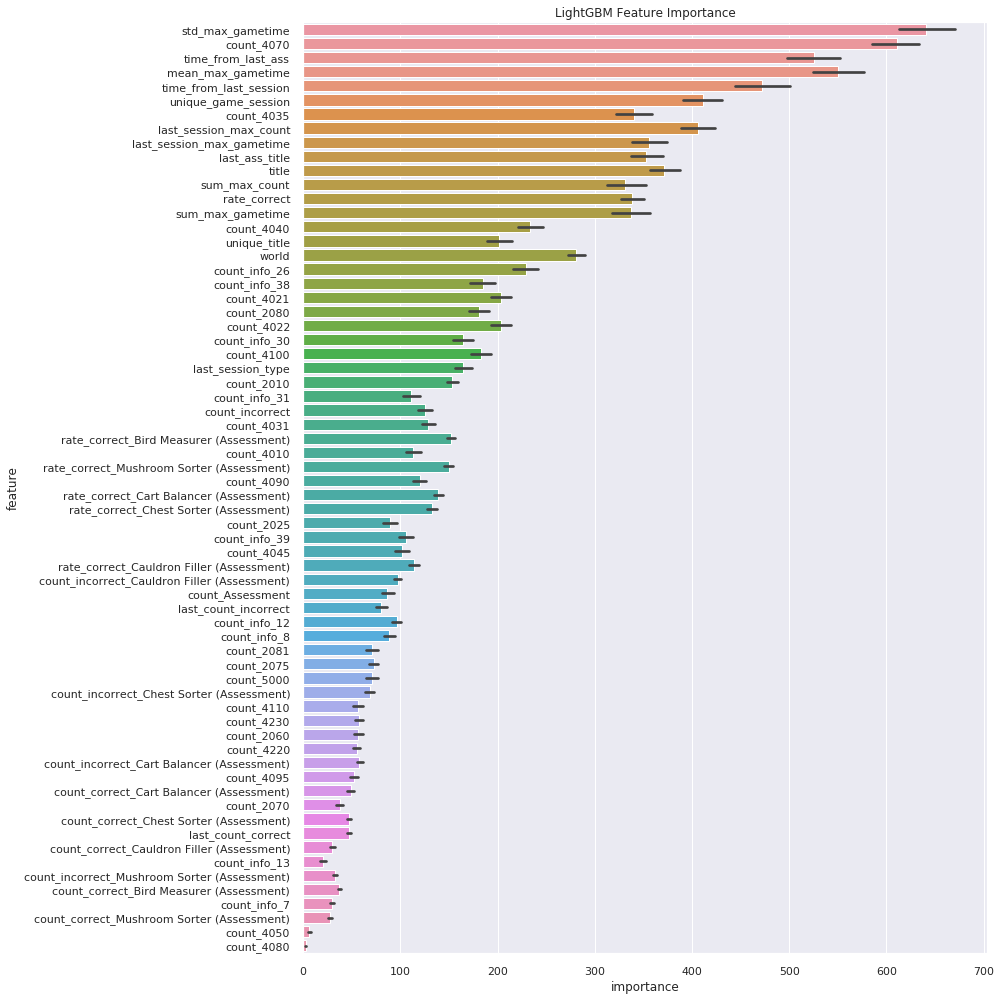

In [22]:
plt.figure(figsize=(14, 14))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

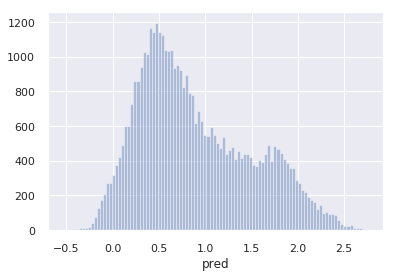

In [23]:
p = pd.DataFrame({"lab":tlabel, "pred":tpred_total,"pclass": np.trunc(tpred_total*100)})
sns.distplot(p[p.lab==0].pred, kde=False, rug=False, bins=100) 

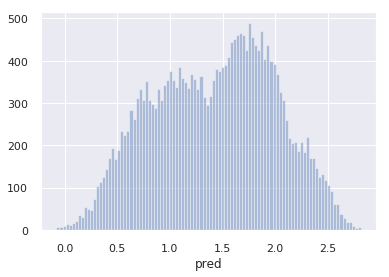

In [24]:
sns.distplot(p[p.lab==1].pred, kde=False, rug=False, bins=100) 

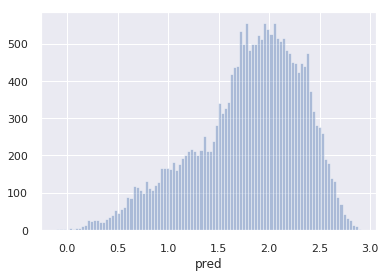

In [25]:
sns.distplot(p[p.lab==2].pred, kde=False, rug=False, bins=100) 

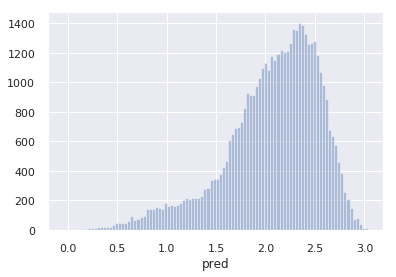

In [26]:
sns.distplot(p[p.lab==3].pred, kde=False, rug=False, bins=100) 

In [27]:
X_train = X_train_origin[~X_train_origin.index.isin(X_train_origin[X_train_origin.accuracy_group==3].sample(frac=len(X_train_origin[X_train_origin.accuracy_group==0])/len(X_train_origin[X_train_origin.accuracy_group==3]),random_state=0).index)].copy()
# X_train = X_train_origin.copy()
psort = tpred_total.copy()
psort.sort()
th1 = psort[int(np.count_nonzero(X_train.accuracy_group<1)/len(X_train)*len(psort))]
th2 = psort[int(np.count_nonzero(X_train.accuracy_group<2)/len(X_train)*len(psort))]
th3 = psort[int(np.count_nonzero(X_train.accuracy_group<3)/len(X_train)*len(psort))]
#th1 = psort[int(np.count_nonzero(val.accuracy_group<1)/len(val)*len(psort))]
#th2 = psort[int(np.count_nonzero(val.accuracy_group<2)/len(val)*len(psort))]
#th3 = psort[int(np.count_nonzero(val.accuracy_group<3)/len(val)*len(psort))]
print(th1,th2,th3)

1.1260474477966447 1.6622330811530595 1.9658755600662703


In [28]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def linear_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the linear weighted kappa
    linear_weighted_kappa calculates the linear weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    linear_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    linear_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = abs(i - j) / float(num_ratings - 1)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the kappa
    kappa calculates the kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            if i == j:
                d = 0.0
            else:
                d = 1.0
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


def weighted_mean_quadratic_weighted_kappa(solution, submission):
    predicted_score = submission[submission.columns[-1]].copy()
    predicted_score.name = "predicted_score"
    if predicted_score.index[0] == 0:
        predicted_score = predicted_score[:len(solution)]
        predicted_score.index = solution.index
    combined = solution.join(predicted_score, how="left")
    groups = combined.groupby(by="essay_set")
    kappas = [quadratic_weighted_kappa(group[1]["essay_score"], group[1]["predicted_score"]) for group in groups]
    weights = [group[1]["essay_weight"].irow(0) for group in groups]
    return mean_quadratic_weighted_kappa(kappas, weights=weights)

In [29]:
X_te_agg = X_test.copy()
X_te_agg["accuracy_group"] = 0
X_te_agg.loc[pred_total > th1,"accuracy_group"] = 1
X_te_agg.loc[pred_total > th2,"accuracy_group"] = 2
X_te_agg.loc[pred_total > th3,"accuracy_group"] = 3
X_te_agg = X_te_agg.merge(test_labels.loc[:,["installation_id","game_session","accuracy_group"]],on=["installation_id","game_session"],how="left")
eval = X_te_agg[~X_te_agg.accuracy_group_y.isna()]
print(quadratic_weighted_kappa(eval.reset_index().accuracy_group_x.astype("int"),eval.reset_index().accuracy_group_y.astype("int")))

X_te_agg["accuracy_group"] = np.where(X_te_agg.accuracy_group_y.isna(),X_te_agg.accuracy_group_x,X_te_agg.accuracy_group_y)
X_te_agg.drop(["accuracy_group_x","accuracy_group_y"],axis=1,inplace=True)
# X_te_agg = X_te_agg.merge(test.loc[(test.type=="Assessment") & (test.event_count==1),["installation_id","game_session","timestamp"]],on=["installation_id","game_session"],how="left")
#print(X_te_agg.head(20))

0.548335469312419


In [30]:
X_te_ans = X_te_agg.iloc[X_te_agg.groupby("installation_id")["timestamp"].idxmax()][["installation_id","accuracy_group"]].astype({"accuracy_group": int}).reset_index()[["installation_id","accuracy_group"]]
# X_te_ans = X_te_agg.groupby("installation_id")["accuracy_group"].last().astype({"accuracy_group": int}).reset_index()
X_te_ans.installation_id = le_id.inverse_transform(X_te_ans.installation_id)
X_te_ans.to_csv("submission.csv",index=False)
print(len(X_te_ans))
print(X_te_ans.head(10))

1000
  installation_id  accuracy_group
0        00abaee7               3
1        01242218               3
2        017c5718               3
3        01a44906               2
4        01bc6cb6               3
5        02256298               3
6        0267757a               1
7        027e7ce5               3
8        02a29f99               0
9        0300c576               1


In [31]:
for i in range(4):
    print(len(X_te_ans[X_te_ans.accuracy_group==i]))

210
164
226
400
